# Face Classification

In [ ]:
from fastai.core import *
from fastai.vision import *
from kgl_deepfake.nb_00 import *
from kgl_deepfake.nb_01a import *
from kgl_deepfake.nb_02a import *
from kgl_deepfake.nb_03 import *

### Data

In [ ]:
SOURCE = Path('../data/')

In [ ]:
train_sample_metadata = pd.read_json('../../data/dfdc_train_part_1/metadata.json').T
train_sample_metadata.head()

,label,split,original
zumqqvixhu.mp4,FAKE,train,hntguogkqd.mp4
utdlsqfykm.mp4,FAKE,train,nswtvttxre.mp4
mdfndlljvt.mp4,FAKE,train,ptkcmwnfjv.mp4
maktypgsfl.mp4,FAKE,train,objgwnmscm.mp4
pleqihjpif.mp4,FAKE,train,xrhqtmxlvx.mp4


How imbalances are our classes ? 

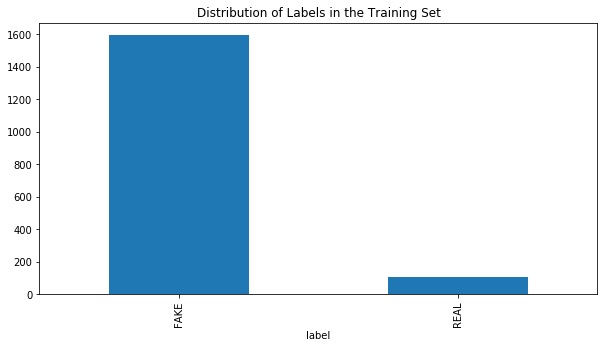

In [ ]:
train_sample_metadata.groupby('label')['label'].count().plot(figsize=(10, 5), kind='bar', title='Distribution of Labels in the Training Set')
plt.show()

It seems indeed that the FAKE faces are over-represented

In [ ]:
(train_sample_metadata['label'] == 'REAL').sum()

108

In [ ]:
(train_sample_metadata['label'] == 'FAKE').sum()

1591

In [ ]:
src = ImageList.from_folder(SOURCE).split_by_folder(train='dfdc_train_part_0', valid='train_sample_faces')

In [ ]:
lab = r'([A-Z]+).png$'

In [ ]:
bs, sz = 32, 128

In [ ]:
def get_data(bs,size):
    data = (src.label_from_re(lab)
           .transform(get_transforms(), size=size)
           .databunch(bs=bs).normalize(imagenet_stats))
    return data

In [ ]:
data = get_data(bs, sz)

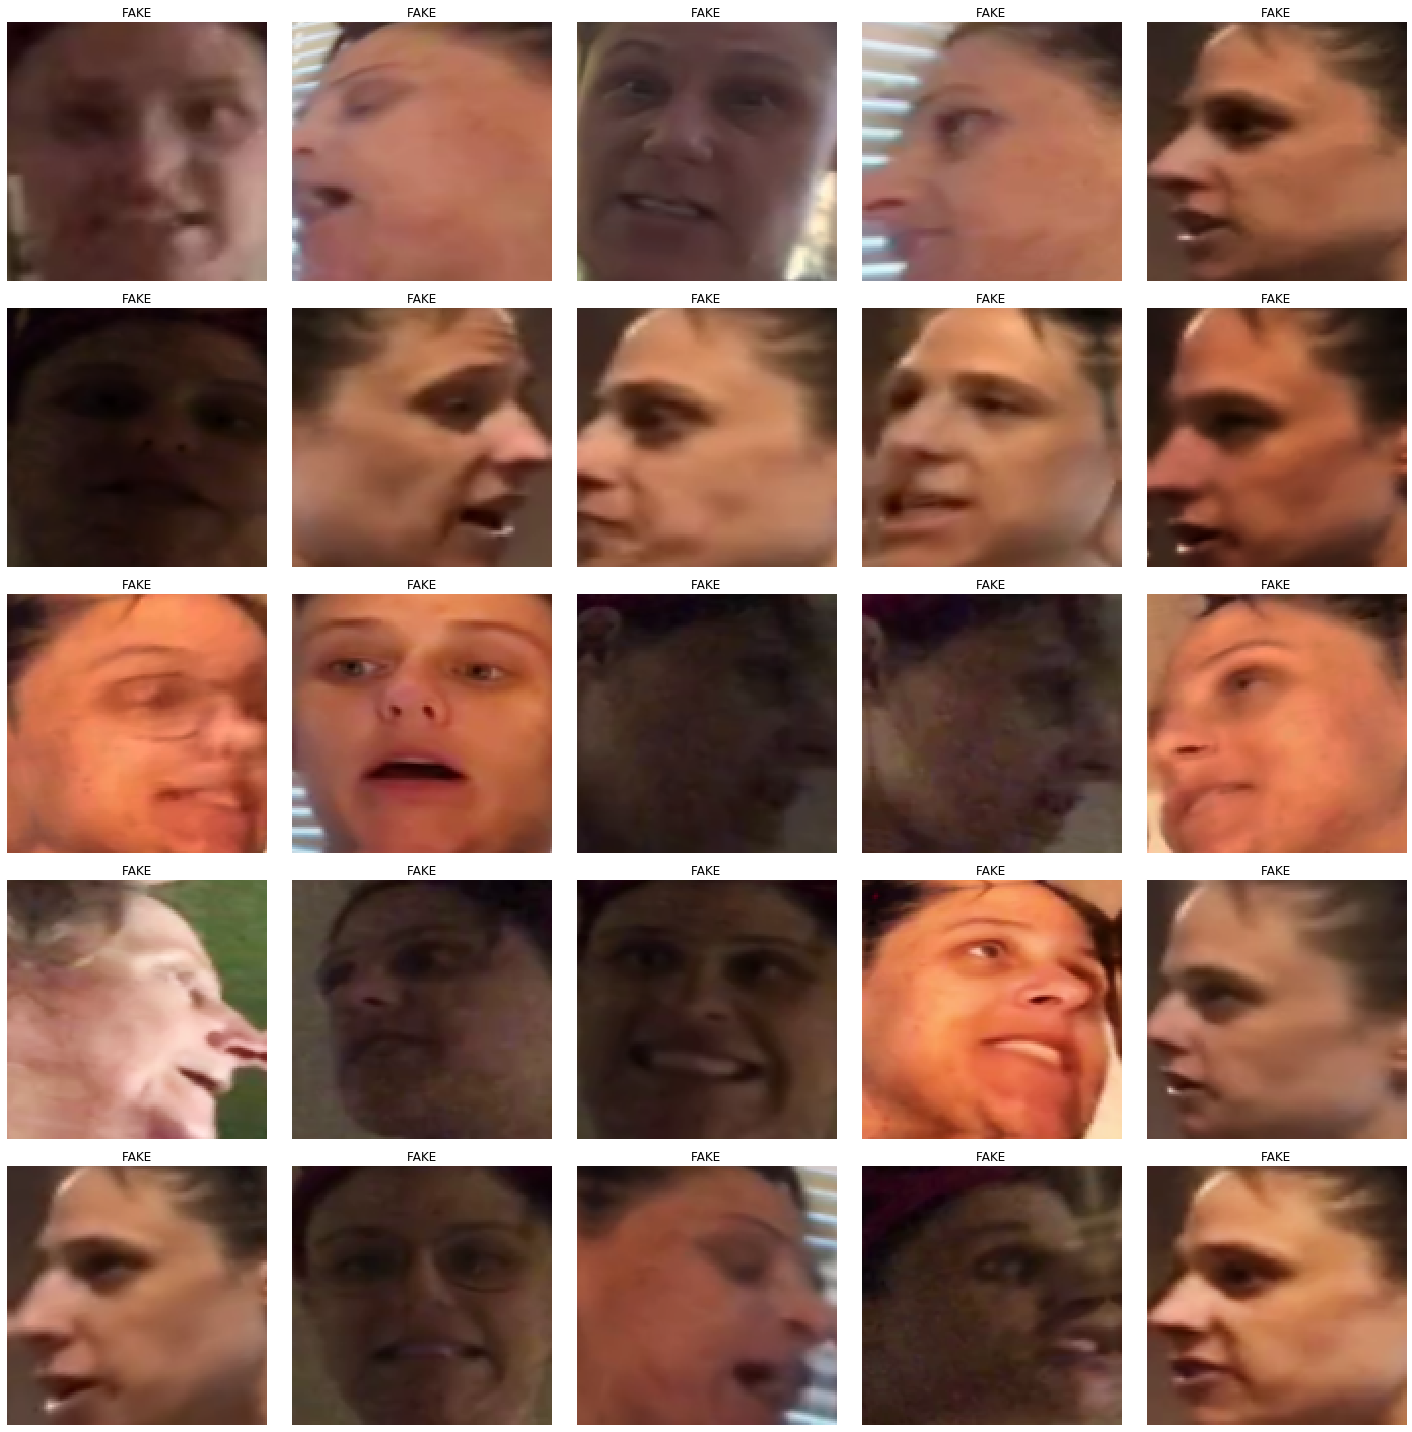

In [ ]:
data.show_batch()

### Model

In [ ]:
net=MesoNet()

To fight the class imbalance, we can use the over sampling technique, which consists of "duplicating" the under-represented class, to get a balance between classes. To be memory efficient, we won't physically duplicate it but just pick samples from the under-represented class more often. This can be achieved with the `OverSamplingCallback` in fastai.

In [ ]:
from fastai.callbacks.oversampling import OverSamplingCallback

Here is the fastai Callback, it:
- Creates weights for each class that are inversely proportionnal to the number of samples in that class.
- Sample randomly data of each class taking the weights into account, so that less represented classes are picked more often.

```python
class OverSamplingCallback(LearnerCallback):
    def __init__(self,learn:Learner,weights:torch.Tensor=None):
        super().__init__(learn)
        self.weights = weights
        
    def on_train_begin(self, **kwargs):
        ds,dl = self.data.train_ds,self.data.train_dl
        self.labels = ds.y.items
        assert np.issubdtype(self.labels.dtype, np.integer), "Can only oversample integer values"
        _,self.label_counts = np.unique(self.labels,return_counts=True)
        if self.weights is None: self.weights = torch.DoubleTensor((1/self.label_counts)[self.labels])
        self.total_len_oversample = int(self.data.c*np.max(self.label_counts))
        sampler = WeightedRandomSampler(self.weights, self.total_len_oversample)
        self.data.train_dl = dl.new(shuffle=False, sampler=sampler)
```

In [ ]:
learn = Learner(data, MesoNet(), metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


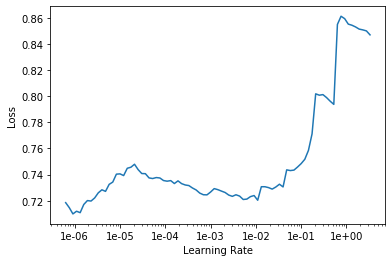

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
epochs, lr = 10, 1e-3

In [ ]:
learn.fit_one_cycle(epochs, lr, callbacks=OverSamplingCallback(learn))

epoch,train_loss,valid_loss,accuracy,time
0,0.713707,0.715534,0.573684,00:02
1,0.691263,0.739660,0.510526,00:02
2,0.666560,0.892969,0.547368,00:02
3,0.654823,0.927274,0.457895,00:02
4,0.642657,0.782583,0.576316,00:02
5,0.630912,0.844550,0.563158,00:02
6,0.595712,0.907635,0.513158,00:02
7,0.564588,0.797597,0.560526,00:02
8,0.550048,0.880208,0.526316,00:03
9,0.555921,0.861741,0.544737,00:02


So now, the accuracy seems a little bit worse than what we had before (~50% compared to 80% before), but it is because now we are using the same amount of sample from each class to train, so no way to cheat anymore !


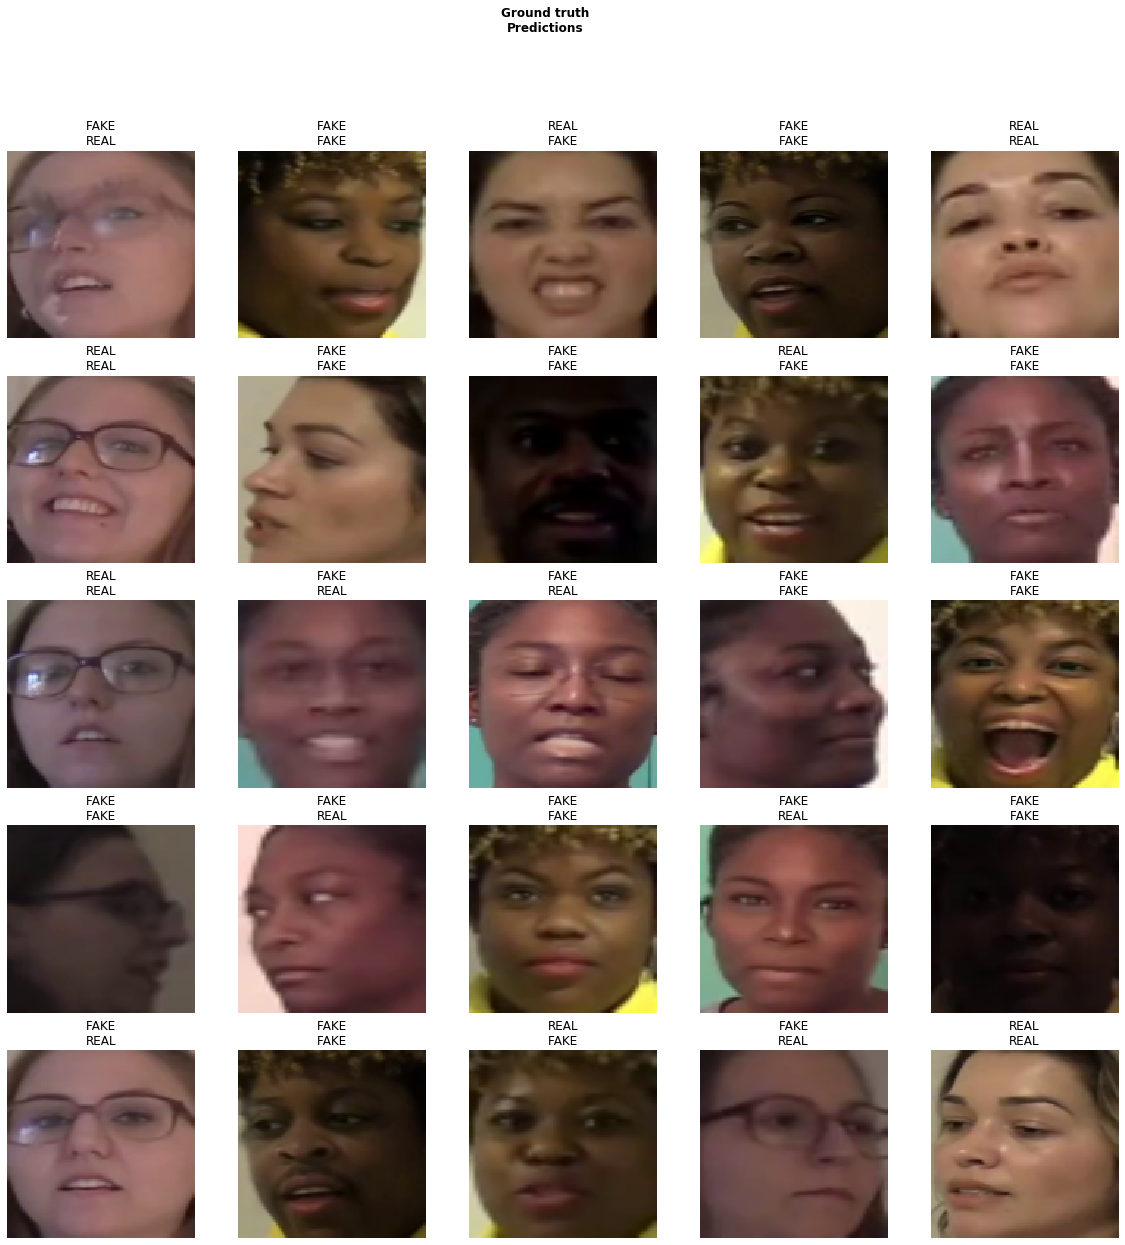

In [ ]:
learn.show_results()

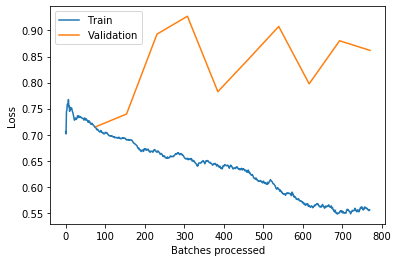

In [ ]:
learn.recorder.plot_losses()

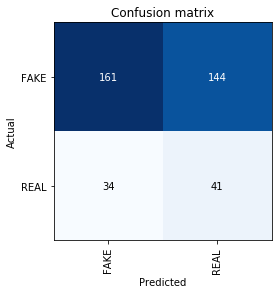

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()